# Set Up

In [ ]:
#@title Install
!pip install torchtext==0.4.0
!pip install transformers

In [ ]:
#@title Imports and Seed
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
import re
from IPython.display import Image
import os
from tqdm import tqdm_notebook as tqdm
import sys
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors, FastText
# import fasttext
import requests
import zipfile

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import urllib
import csv
from scipy.special import softmax

seed = 522
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

TPU address is grpc://10.66.218.250:8470


In [ ]:
!pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl (152.9 MB)


In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm
# Creates a random tensor on xla:1 (a Cloud TPU core)
dev = xm.xla_device()
second_dev = xm.xla_device(n=2, devkind='TPU')

In [ ]:
dev

device(type='xla', index=1)

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/Shared drives/CIS522_Final_Project/Data/meta_all_beauty_cleaned.csv')
data = data.drop(['Unnamed: 0', 'category'], axis = 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32488 entries, 0 to 32487
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   description     32488 non-null  object 
 1   title           32487 non-null  object 
 2   also_buy        32488 non-null  object 
 3   brand           16917 non-null  object 
 4   feature         32488 non-null  object 
 5   also_view       32488 non-null  object 
 6   main_cat        32488 non-null  object 
 7   similar_item    1300 non-null   object 
 8   date            19 non-null     object 
 9   price           11348 non-null  object 
 10  asin            32488 non-null  object 
 11  rank_in_beauty  32086 non-null  float64
dtypes: float64(1), object(11)
memory usage: 3.0+ MB


In [ ]:
data.head()

,description,title,also_buy,brand,feature,also_view,main_cat,similar_item,date,price,asin,rank_in_beauty
0,"[""Loud 'N Clear Personal Sound Amplifier allow...",Loud 'N Clear&trade; Personal Sound Amplifier,[],idea village,[],[],All Beauty,NaN,NaN,NaN,6546546450,2938573.0
1,['No7 Lift & Luminate Triple Action Serum 50ml...,No7 Lift &amp; Luminate Triple Action Serum 50...,"['B01E7LCSL6', 'B008X5RVME']",NaN,[],[],All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",NaN,$44.99,7178680776,872854.0
2,"[""No7 Stay Perfect Foundation now stays perfec...",No7 Stay Perfect Foundation Cool Vanilla by No7,[],No7,[],"['B01B8BR0O8', 'B01B8BR0NO', 'B014MHXXM8']",All Beauty,NaN,NaN,$28.76,7250468162,956696.0
3,[],Wella Koleston Perfect Hair Colour 44/44 Mediu...,['B0041PBXX8'],NaN,[],[],All Beauty,NaN,NaN,NaN,7367905066,1870258.0
4,['Lacto Calamine Skin Balance Daily Nourishing...,Lacto Calamine Skin Balance Oil control 120 ml...,[],Pirmal Healthcare,[],"['3254895630', 'B007VL1D9S', 'B00EH9A0RI', 'B0...",All Beauty,NaN,NaN,$12.15,7414204790,67701.0


In [ ]:
import ast
# preprocessing: merge also_buy & also_view to similar_products, drop duplicated asins
desc_data = data[['asin', 'description', 'also_view', 'also_buy']]
desc_data = desc_data[desc_data['description'] != '[]']
desc_data['also_buy'] = desc_data['also_buy'].apply(lambda x: [n.strip() for n in ast.literal_eval(x)])
desc_data['also_view'] = desc_data['also_view'].apply(lambda x: [n.strip() for n in ast.literal_eval(x)])
desc_data['similar_products'] = desc_data['also_buy'] + desc_data['also_view']
desc_data = desc_data[desc_data.duplicated(subset=['asin'], keep="first") == False]
desc_data.reset_index(inplace=True, drop=True)

In [ ]:
desc_data

,asin,description,also_view,also_buy,similar_products
0,6546546450,"[""Loud 'N Clear Personal Sound Amplifier allow...",[],[],[]
1,7178680776,['No7 Lift & Luminate Triple Action Serum 50ml...,[],"[B01E7LCSL6, B008X5RVME]","[B01E7LCSL6, B008X5RVME]"
2,7250468162,"[""No7 Stay Perfect Foundation now stays perfec...","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",[],"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]"
3,7414204790,['Lacto Calamine Skin Balance Daily Nourishing...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",[],"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4..."
4,7535842801,['Mary Kay Satin Hands Peach Hand Cream Travel...,[],[],[]
...,...,...,...,...,...
14827,B01HIHLFOC,['Move over soap on a rope! This heavy-duty Br...,[B07HXRQ4RC],[],[B07HXRQ4RC]
14828,B01HIPOQ2M,['Eau de parfum spray vial mini design house: ...,"[B071CLPG9H, B00UPF366U, B06XFYMCCG, B07G3JW6P...","[B00UPF366U, B071CLPG9H, B018089E28, B06XFYMCC...","[B00UPF366U, B071CLPG9H, B018089E28, B06XFYMCC..."
14829,B01HIUEEHO,['Pokemon Plush 9.2 Inch / 23cm Gengar Doll St...,"[B07GRSZJJQ, B07KWLV8L4, B015XSKKEY, B00TV405K...",[B00YSWUDGM],"[B00YSWUDGM, B07GRSZJJQ, B07KWLV8L4, B015XSKKE..."
14830,B01HIWKGOM,['New and unused product. 100% authentic Benef...,"[B004K0MSOM, B01I9TO6RQ, B000FBNYOI]","[B000FBF58G, B001L1H8DY, B01HOWZ376]","[B000FBF58G, B001L1H8DY, B01HOWZ376, B004K0MSO..."


In [ ]:
def tokenized_content(content):
  res = ''
  word = nltk.word_tokenize(content)
  for token in word:
    if token.isalpha() and token.lower() not in stopwords:
      res += token.lower() + ' '
  return res

In [ ]:
desc_data["clean_description"] = desc_data['description'].str.replace('[^\w\s]','')
desc_data['clean_description'] = desc_data['clean_description'].apply(lambda x: tokenized_content(x))
X = desc_data['clean_description'].to_list()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


# Utility

In [ ]:
def calculate_cos_similarity(vector1, vector2):
    '''
    vector1, vector2: np array
    '''
    return np.dot(vector1, vector2)/(np.linalg.norm(vector1) * np.linalg.norm(vector2))

def measure_within_distance(row):
    distances = []
    for product in row.similar_products:
        if product in asin_set:
            distances.append(calculate_cos_similarity(row.embedding, embedding_dict[product]))
    if distances:
        return sum(distances) / len(distances)

def measure_between_distance(row):
    if row.within_distance: # only calculate between distance for rows with within distance
        distances = []
        for asin in random.sample(asin_set, 10):
            if asin not in row.similar_products:
                distances.append(calculate_cos_similarity(row.embedding, embedding_dict[asin]))
    if distances:
        return sum(distances) / len(distances)

# EDA

In [ ]:
asin_lst = desc_data['asin'].to_list()

In [ ]:
target = desc_data['target'].to_list()

In [ ]:
match_cnt = []
for item in target:
  cnt = 0
  for i in item:
    if i.strip() in asin_lst:
      cnt += 1
  match_cnt.append(cnt)

In [ ]:
match_df = pd.DataFrame(data = {'cnt': match_cnt})
match_df['cnt'].value_counts()

0     2955
1      370
2      106
3       48
4       19
6        8
5        8
16       3
11       3
8        3
7        2
15       1
12       1
13       1
9        1
10       1
Name: cnt, dtype: int64

In [ ]:
desc_data

,asin,description,also_view,also_buy,target
0,6546546450,"[""Loud 'N Clear Personal Sound Amplifier allow...",[],[],"[, ]"
1,7178680776,['No7 Lift & Luminate Triple Action Serum 50ml...,[],"['B01E7LCSL6', 'B008X5RVME']","['B01E7LCSL6', 'B008X5RVME', ]"
2,7250468162,"[""No7 Stay Perfect Foundation now stays perfec...","['B01B8BR0O8', 'B01B8BR0NO', 'B014MHXXM8']",[],"[, 'B01B8BR0O8', 'B01B8BR0NO', 'B014MHXXM8']"
4,7414204790,['Lacto Calamine Skin Balance Daily Nourishing...,"['3254895630', 'B007VL1D9S', 'B00EH9A0RI', ...",[],"[, '3254895630', 'B007VL1D9S', 'B00EH9A0RI',..."
5,7535842801,['Mary Kay Satin Hands Peach Hand Cream Travel...,[],[],"[, ]"
...,...,...,...,...,...
32476,B01HIHLFOC,['Move over soap on a rope! This heavy-duty Br...,['B07HXRQ4RC'],[],"[, 'B07HXRQ4RC']"
32480,B01HIPOQ2M,['Eau de parfum spray vial mini design house: ...,"['B071CLPG9H', 'B00UPF366U', 'B06XFYMCCG', ...","['B00UPF366U', 'B071CLPG9H', 'B018089E28', ...","['B00UPF366U', 'B071CLPG9H', 'B018089E28', ..."
32481,B01HIUEEHO,['Pokemon Plush 9.2 Inch / 23cm Gengar Doll St...,"['B07GRSZJJQ', 'B07KWLV8L4', 'B015XSKKEY', ...",['B00YSWUDGM'],"['B00YSWUDGM', 'B07GRSZJJQ', 'B07KWLV8L4', '..."
32482,B01HIWKGOM,['New and unused product. 100% authentic Benef...,"['B004K0MSOM', 'B01I9TO6RQ', 'B000FBNYOI']","['B000FBF58G', 'B001L1H8DY', 'B01HOWZ376']","['B000FBF58G', 'B001L1H8DY', 'B01HOWZ376', '..."


In [ ]:
desc_data['description'].value_counts()

['For over 60 years, Betty Dain Creations, Inc. has designed and manufactured products for the beauty industry. We listen, we create and we execute for success.']                                                                                                                                                                                                                                                                                                                 59
['Brand New']                                                                                                                                                                                                                                                                                                                                                                                                                                                                      35
['5']                                                       

In [ ]:
desc_data[['description','clean_description']]

,description,clean_description
0,"[""Loud 'N Clear Personal Sound Amplifier allow...",loud n clear personal sound amplifier allows t...
1,['No7 Lift & Luminate Triple Action Serum 50ml...,lift luminate triple action serum boots
2,"[""No7 Stay Perfect Foundation now stays perfec...",stay perfect foundation stays perfect longer h...
4,['Lacto Calamine Skin Balance Daily Nourishing...,lacto calamine skin balance daily nourishing l...
5,['Mary Kay Satin Hands Peach Hand Cream Travel...,mary kay satin hands peach hand cream travel s...
...,...,...
32476,['Move over soap on a rope! This heavy-duty Br...,move soap rope heavyduty brick soap keep even ...
32480,['Eau de parfum spray vial mini design house: ...,eau de parfum spray vial mini design house yve...
32481,['Pokemon Plush 9.2 Inch / 23cm Gengar Doll St...,pokemon plush inch gengar doll stuffed animals...
32482,['New and unused product. 100% authentic Benef...,new unused product authentic benefit cosmetics...


# Pretrained Bert

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
# tokenizer = tokenizer.to(dev)
model = model.to(dev)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
res = torch.randn(len(X), 768, device=dev)

In [ ]:
#  use only the 'CLS' output of the last layer as sentence rep
# 25s
for i in range(0, len(X), 100):
  # print('batch i', i)
  encoded_inputs = tokenizer(X[i:i+100], padding='max_length', max_length = 16, 
                              truncation=True, return_tensors="pt")
  ids = encoded_inputs['input_ids'].to(dev)
  mask = encoded_inputs['attention_mask'].to(dev)

  output = model(ids, mask)
  final_layer = output.last_hidden_state
  res[i:i+100] = final_layer[:,0,:]

In [ ]:
tokenizer('Hi, this is ben.')

{'input_ids': [101, 7632, 1010, 2023, 2003, 3841, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
res_detach = res.cpu().detach().numpy()

In [ ]:
desc_data['embedding'] = res_detach.tolist()

In [ ]:
desc_data.head()

,asin,description,also_view,also_buy,similar_products,clean_description,embedding
0,6546546450,"[""Loud 'N Clear Personal Sound Amplifier allow...",[],[],[],loud n clear personal sound amplifier allows t...,"[-0.35943371057510376, 0.05434437096118927, 0...."
1,7178680776,['No7 Lift & Luminate Triple Action Serum 50ml...,[],"[B01E7LCSL6, B008X5RVME]","[B01E7LCSL6, B008X5RVME]",lift luminate triple action serum boots,"[-0.3542182743549347, 0.2864765524864197, -0.1..."
2,7250468162,"[""No7 Stay Perfect Foundation now stays perfec...","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",[],"[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]",stay perfect foundation stays perfect longer h...,"[0.09367882460355759, -0.35300368070602417, 0...."
3,7414204790,['Lacto Calamine Skin Balance Daily Nourishing...,"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",[],"[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...",lacto calamine skin balance daily nourishing l...,"[-0.6010698080062866, 0.07387758046388626, -0...."
4,7535842801,['Mary Kay Satin Hands Peach Hand Cream Travel...,[],[],[],mary kay satin hands peach hand cream travel s...,"[-0.4726327061653137, -0.23180145025253296, -0..."


In [ ]:
print('Example description: ', desc_data['clean_description'][0])
print('Example embedding: ', desc_data['embedding'][0])

Example description:  loud n clear personal sound amplifier allows turn volume people around saying listen level want without disturbing others hear pin drop across room 
Example embedding:  [-0.35943371057510376, 0.05434437096118927, 0.22126926481723785, 0.0023093828931450844, -0.2488357424736023, 0.044786661863327026, 0.44365596771240234, 0.26496973633766174, -0.09071402996778488, -0.4381644129753113, 0.16634789109230042, -0.07274460047483444, 0.23755860328674316, 0.23339220881462097, -0.5126676559448242, -0.2403193712234497, 0.1589212864637375, 0.644504189491272, 0.02008146047592163, 0.18382737040519714, 0.2675970196723938, -0.6779509782791138, 0.5223103165626526, -0.1833650767803192, -0.16390185058116913, -0.10901595652103424, 0.09794207662343979, 0.026706121861934662, -0.16202287375926971, -0.005745064467191696, -0.042276740074157715, 0.5436974763870239, -0.19445213675498962, -0.6275398135185242, 0.42839521169662476, -0.3309504985809326, -0.10045887529850006, -0.1399022787809372, 

In [ ]:
def calculate_cos_similarity(vector1, vector2):
    '''
    vector1, vector2: np array
    '''
    return np.dot(vector1, vector2)/(np.linalg.norm(vector1) * np.linalg.norm(vector2))

def measure_within_distance(row):
    distances = []
    for product in row.similar_products:
        if product in asin_set:
            distances.append(calculate_cos_similarity(row.embedding, embedding_dict[product]))
    if distances:
        return sum(distances) / len(distances)

def measure_between_distance(row):
    if row.within_distance: # only calculate between distance for rows with within distance
        distances = []
        for asin in random.sample(asin_set, 10):
            if asin not in row.similar_products:
                distances.append(calculate_cos_similarity(row.embedding, embedding_dict[asin]))
    if distances:
        return sum(distances) / len(distances)

In [ ]:
# original 768 dim, max_padding = 16
# asin set
asin_set = set(desc_data["asin"])
# create quick access to embeddings
embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
# calcualte distance
desc_data["within_distance"] = desc_data.apply(measure_within_distance, axis=1)
desc_data["between_distance"] = desc_data.apply(measure_between_distance, axis=1)
# print results
print("within_distance: ", desc_data["within_distance"].mean())
print("between_distance: ", desc_data["between_distance"].mean())

within_distance:  0.8840232691725115
between_distance:  0.8242023540583076


In [ ]:
desc_data["distance"].value_counts()

1.000000    72
1.000000    46
1.000000    46
0.860837     3
0.859345     3
            ..
0.712520     1
0.789941     1
0.867687     1
0.807091     1
0.733362     1
Name: distance, Length: 1049, dtype: int64

In [ ]:
desc_data["distance"].describe()

count    1344.000000
mean        0.879490
std         0.076319
min         0.378618
25%         0.836561
50%         0.875450
75%         0.923728
max         1.000000
Name: distance, dtype: float64

In [ ]:
# last batch size: 32
final_layer.shape

torch.Size([32, 10, 768])

In [ ]:
# final_layer

tensor([[[-0.3569,  0.2864, -0.2029,  ..., -0.4006, -0.0092,  0.2395],
         [ 0.2705,  0.4568,  0.0356,  ..., -0.2961, -0.2262, -0.2289],
         [-0.0090, -1.1808,  0.1261,  ..., -0.3218, -0.5571, -0.3033],
         ...,
         [-0.0849, -0.2953, -0.6385,  ...,  0.2384, -0.0944, -0.1953],
         [ 0.6702,  0.1260, -0.3862,  ...,  0.0258, -0.8893, -0.2996],
         [-0.0913,  0.0051, -0.0419,  ..., -0.1664, -0.1351, -0.0333]]],
       grad_fn=<NativeLayerNormBackward0>)

In [ ]:
# original 768 dim, max_padding = 32
# asin set
asin_set = set(desc_data["asin"])
# create quick access to embeddings
embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
# calcualte distance
desc_data["distance"] = desc_data.apply(measure_distance, axis=1)
# print results
print(desc_data["distance"].mean())

0.8884327890257228


In [ ]:
desc_data["distance"].describe()

count    1344.000000
mean        0.888433
std         0.070790
min         0.354968
25%         0.851150
50%         0.887785
75%         0.927303
max         1.000000
Name: distance, dtype: float64

## PCA for dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
x = [8, 16, 32, 64, 128, 256, 512]
within = []
between = []

In [ ]:
res_detach.shape

(14832, 768)

In [ ]:
res_detach_pca.shape

(14832, 512)

In [ ]:
for i in range(len(x)):
  pca = PCA(n_components=x[i])
  res_detach_pca = pca.fit_transform(res_detach) 
  print('shape', res_detach_pca.shape) 
  desc_data['embedding'] = res_detach_pca.tolist()

  asin_set = set(desc_data["asin"])
  # create quick access to embeddings
  embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
  # calcualte distance
  desc_data["within_distance"] = desc_data.apply(measure_within_distance, axis=1)
  desc_data["between_distance"] = desc_data.apply(measure_between_distance, axis=1)
  within_mean =  desc_data["within_distance"].mean()
  between_mean = desc_data["between_distance"].mean()
  within.append(within_mean)
  between.append(between_mean)
  # print results
  print("within_distance: ",within_mean)
  print("between_distance: ",between_mean)

shape (14832, 8)
within_distance:  0.39698485517796445
between_distance:  0.0032934614003973135
shape (14832, 16)
within_distance:  0.37756284924128786
between_distance:  0.0011352113945819477
shape (14832, 32)
within_distance:  0.36725220945879833
between_distance:  0.0007337721043519046
shape (14832, 64)
within_distance:  0.35637489608692785
between_distance:  0.0002715279472732654
shape (14832, 128)
within_distance:  0.3462717877896247
between_distance:  0.0009789873287108005
shape (14832, 256)
within_distance:  0.3354864298976077
between_distance:  0.0006996348651260112
shape (14832, 512)
within_distance:  0.32754688706679347
between_distance:  0.0007548025996537608


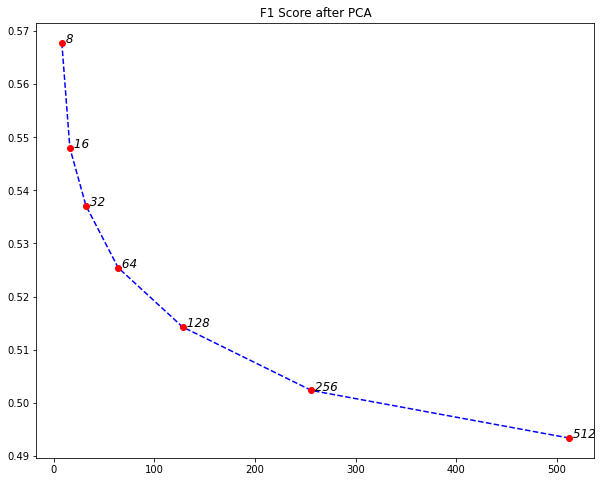

In [ ]:
f1 = [ 2*within[i]*(1-between[i])/(within[i] + 1 - between[i]) for i in range(len(x))]

# # Plot 1st line
# plt.plot(x, within, 'g', linestyle= 'dashed')

# # Plot 2nd line
# plt.plot(x, between, 'b', linestyle = 'dashed')

# Plot 3rd line

plt.figure(figsize=(10,8))

plt.title("F1 Score after PCA")
plt.plot(x, f1, 'b', linestyle = 'dashed')

for i in range(len(x)):
  plt.plot(x[i],f1[i],'ro')
for i, j in zip(x, f1):
  #  plt.text(i, j, '({}, {:.2f})'.format(i, j), horizontalalignment='center')
   plt.text(i, j, ' '+ str(i), horizontalalignment='left', fontsize = 'large', fontstyle = 'italic')
# Display

plt.show()

In [ ]:
f1

[0.5678120746780524,
 0.5479899200260901,
 0.5371061523951443,
 0.5254439133672932,
 0.5142862460552347,
 0.5023299798022296,
 0.4933699223211383]

In [ ]:
within

[0.39698485517796445,
 0.37756284924128786,
 0.36725220945879833,
 0.35637489608692785,
 0.3462717877896247,
 0.3354864298976077,
 0.32754688706679347]

## Use CLS of the last four layers as sentence representation

In [ ]:
bert_res_4 = torch.randn(len(X), 768, device=dev)

In [ ]:
# https://towardsdatascience.com/what-exactly-happens-when-we-fine-tune-bert-f5dc32885d76#:~:text=Authors%20Jacob%20Devlin%20et%20al,for%20just%20a%20few%20epochs.
# https://arxiv.org/pdf/1810.04805.pdf

# use the CLS of last four layers and take average
for i in range(0, len(X), 100):
  # print('batch i', i)
  encoded_inputs = tokenizer(X[i:i+100], padding='max_length', max_length = 16, 
                              truncation=True, return_tensors="pt")
  ids = encoded_inputs['input_ids'].to(dev)
  mask = encoded_inputs['attention_mask'].to(dev)

  # dim output = (last_hidden_state, pooler_output, hidden_states, attentions)
  # dim hidden_states:
  output = model(ids, mask)
  # access all the hidden states of the 12 layers
  all_hidden_states = output[2][1:]  # dim output[2]: (13, batch size, word count, word dim)
  # access only the last four layers
  token_embeddings = torch.stack(all_hidden_states[-4:], dim=0)
  # reshape: [4, 100, 10, 768] (# of layers, batch_size, num_words, word_dim) 
  #           -> [10, 100, 4, 768] (num_words, batch_size, # of layer, word_dim)
  token_embeddings = token_embeddings.permute(2,1,0,3)
  # only take the output of 'CLS' pos
  token_embeddings = token_embeddings[0, :, :, :]
  # take average of 'CLS' in the last four layers
  bert_res_4[i:i+100] = torch.mean(token_embeddings, dim=1)

In [ ]:
bert_res_4_detacch = bert_res_4.cpu().detach().numpy()

In [ ]:
desc_data['embedding'] = bert_res_4_detacch.tolist()

In [ ]:
asin_set = set(desc_data["asin"])
# create quick access to embeddings
embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
# calcualte distance
desc_data["within_distance"] = desc_data.apply(measure_within_distance, axis=1)
desc_data["between_distance"] = desc_data.apply(measure_between_distance, axis=1)
# print results
print("within_distance: ", desc_data["within_distance"].mean())
print("between_distance: ", desc_data["between_distance"].mean())

within_distance:  0.8852253839426771
between_distance:  0.8284938589032296


In [ ]:
w = desc_data["within_distance"].mean()
b =  desc_data["between_distance"].mean()

In [ ]:
print('f1:', 2*w*(1-b)/(w+1-b))

f1: 0.2873418384962975


In [ ]:
desc_data["distance"].describe()

count    1344.000000
mean        0.863622
std         0.082060
min         0.394619
25%         0.814117
50%         0.856443
75%         0.909612
max         1.000000
Name: distance, dtype: float64

## Use the CLS of all 12 layers as sentence representation

In [ ]:
bert_res_12 = torch.randn(len(X), 768, device=dev)

In [ ]:
# use the CLS of all 12 layers and take average
for i in range(0, len(X), 100):
  # print('batch i', i)
  encoded_inputs = tokenizer(X[i:i+100], padding='max_length', max_length = 16, 
                              truncation=True, return_tensors="pt")
  ids = encoded_inputs['input_ids'].to(dev)
  mask = encoded_inputs['attention_mask'].to(dev)

  # dim output = (last_hidden_state, pooler_output, hidden_states, attentions)
  # dim hidden_states:
  output = model(ids, mask)
  # access all the hidden states of the 12 layers
  all_hidden_states = output[2][1:]  # dim output[2]: (13, batch size, word count, word dim)
  # access only the last four layers
  token_embeddings = torch.stack(all_hidden_states[:], dim=0)
  # reshape: [4, 100, 10, 768] (# of layers, batch_size, num_words, word_dim) 
  #           -> [10, 100, 4, 768] (num_words, batch_size, # of layer, word_dim)
  token_embeddings = token_embeddings.permute(2,1,0,3)
  token_embeddings = token_embeddings[0, :, :, :]
  bert_res_12[i:i+100] = torch.mean(token_embeddings, dim=1)

In [ ]:
bert_res_12_detacch = bert_res_12.cpu().detach().numpy()

In [ ]:
desc_data['embedding'] = bert_res_12_detacch.tolist()

In [ ]:
asin_set = set(desc_data["asin"])
# create quick access to embeddings
embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
# calcualte distance
desc_data["within_distance"] = desc_data.apply(measure_within_distance, axis=1)
desc_data["between_distance"] = desc_data.apply(measure_between_distance, axis=1)
# print results
print("within_distance: ", desc_data["within_distance"].mean())
print("between_distance: ", desc_data["between_distance"].mean())

within_distance:  0.9641583530661186
between_distance:  0.9448987628857475


In [ ]:
w = desc_data["within_distance"].mean()
b =  desc_data["between_distance"].mean()
print('f1:', 2*w*(1-b)/(w+1-b))

In [ ]:
print('f1:', 2*w*(1-b)/(w+1-b))

f1: 0.10424492158780083


## Dimensionality Reduction using Whitening

In [ ]:
# https://deep-ch.medium.com/dimension-reduction-by-whitening-bert-roberta-5e103093f782
# https://arxiv.org/pdf/2103.15316.pdf

def transform_and_normalize(vecs, kernel, bias):
    """
        Applying transformation then standardize
    """
    if not (kernel is None or bias is None):
        vecs = (vecs + bias).dot(kernel)
    return normalize(vecs)
    
def normalize(vecs):
    """
        Standardization
    """
    return vecs / (vecs**2).sum(axis=1, keepdims=True)**0.5
    
def compute_kernel_bias(vecs):
    """
    Calculate Kernal & Bias for the final transformation - y = (x + bias).dot(kernel)
    """
    vecs = np.concatenate(vecs, axis=0)
    mu = vecs.mean(axis=0, keepdims=True)
    cov = np.cov(vecs.T)
    u, s, vh = np.linalg.svd(cov)
    W = np.dot(u, np.diag(s**0.5))
    W = np.linalg.inv(W.T)
    return W, -mu


In [ ]:
res_detach.shape

(14832, 768)

In [ ]:
def embedding_whitening(vector, length):
  #Finding Kernal
  kernel, bias = compute_kernel_bias([vector])
  kernel = kernel[:, :length]
  #If you want to reduce it to 128 dim
  #kernel = kernel[:, :128]
  embeddings = []
  embeddings = np.vstack(res_detach)

  #Sentence embeddings can be converted into an identity matrix
  #by utilizing the transformation matrix
  embeddings = transform_and_normalize(embeddings, 
            kernel=kernel,
            bias=bias
        )

  return embeddings

In [ ]:
import copy
res_white = copy.deepcopy(res_detach)
res_white.shape

(14832, 768)

In [ ]:
within = []
between = []
x = [8, 16, 32, 64, 128, 256, 512]

In [ ]:
for i in range(len(x)):
  embeddings = embedding_whitening(res_white, x[i])
  print('embedding shape', embeddings.shape)
  desc_data['embedding'] = embeddings.tolist()

  asin_set = set(desc_data["asin"])
  # create quick access to embeddings
  embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
  # calcualte distance
  desc_data["within_distance"] = desc_data.apply(measure_within_distance, axis=1)
  desc_data["between_distance"] = desc_data.apply(measure_between_distance, axis=1)
  within_mean = desc_data["within_distance"].mean()
  between_mean = desc_data["between_distance"].mean()
  within.append(within_mean)
  between.append(between_mean)
  # print results
  print("within_distance: ", within_mean)
  print("between_distance: ", between_mean)

embedding shape (14832, 8)
within_distance:  0.39971998382436713
between_distance:  0.0016388081682890878
embedding shape (14832, 16)
within_distance:  0.362078202922651
between_distance:  0.0018688755257359768
embedding shape (14832, 32)
within_distance:  0.34294916019696686
between_distance:  0.00045629963784298434
embedding shape (14832, 64)
within_distance:  0.3219347281024604
between_distance:  0.0012158553171994291
embedding shape (14832, 128)
within_distance:  0.29776035236241255
between_distance:  0.0005142572888545808
embedding shape (14832, 256)
within_distance:  0.2675932046446953
between_distance:  4.948006481006037e-05
embedding shape (14832, 512)
within_distance:  0.2417305731087407
between_distance:  8.307925352618326e-05


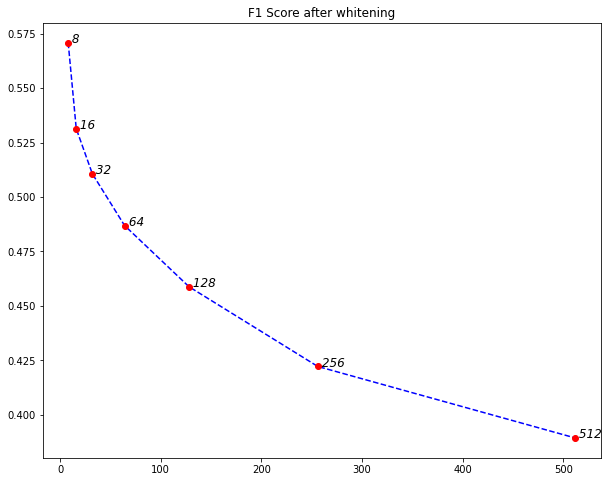

In [ ]:
f1 = [ 2*within[i]*(1-between[i])/(within[i] + 1 - between[i]) for i in range(len(x))]

plt.figure(figsize=(10,8))

plt.title("F1 Score after whitening")
plt.plot(x, f1, 'b', linestyle = 'dashed')

for i in range(len(x)):
  plt.plot(x[i],f1[i],'ro')
for i, j in zip(x, f1):
  #  plt.text(i, j, '({}, {:.2f})'.format(i, j), horizontalalignment='center')
   plt.text(i, j, ' '+ str(i), horizontalalignment='left', fontsize = 'large', fontstyle = 'italic')
# Display

plt.show()

# Pretrained Roberta

In [ ]:
# https://arxiv.org/abs/1907.11692

from transformers import RobertaTokenizer, RobertaModel

robo_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
robo_model = RobertaModel.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
robo_model = robo_model.to(dev)
robo_res = torch.randn(len(X), 768, device=dev)

In [ ]:
for i in range(0, len(X), 100):
  # print('batch i', i)
  robo_encoded_inputs = robo_tokenizer(X[i:i+100], padding='max_length', max_length = 16, 
                              truncation=True, return_tensors="pt")
  robo_ids = robo_encoded_inputs['input_ids'].to(dev)
  robo_mask = robo_encoded_inputs['attention_mask'].to(dev)

  robo_output = robo_model(robo_ids, robo_mask)
  robo_final_layer = robo_output.last_hidden_state
  # final_layer: batch_size*input_length*feature_dim, take only the first output
  robo_res[i:i+100] = robo_final_layer[:,0,:]

In [ ]:
robo_res_detach = robo_res.cpu().detach().numpy()

In [ ]:
len(robo_res_detach[0])

768

In [ ]:
desc_data['embedding'] = robo_res_detach.tolist()

In [ ]:
print('Example description: ', desc_data['clean_description'][0])
print('Example embedding: ', desc_data['embedding'][0])

Example description:  loud n clear personal sound amplifier allows turn volume people around saying listen level want without disturbing others hear pin drop across room 
Example embedding:  [-0.02735801786184311, 0.0783117413520813, -0.021099574863910675, -0.11026514321565628, 0.06001994013786316, -0.1119818389415741, -0.03824414312839508, 0.01696351170539856, 0.05020599439740181, -0.08148089051246643, 0.00855221040546894, 0.070497527718544, 0.023632321506738663, -0.02380601316690445, 0.07107730209827423, 0.033492155373096466, -0.06447114795446396, 0.0156419575214386, -0.0020947828888893127, -0.05242548882961273, -0.07760872691869736, 0.020509924739599228, -0.029644235968589783, 0.11938296258449554, -0.009366575628519058, -0.004889616742730141, 0.048275284469127655, 0.09261232614517212, -0.038956426084041595, -0.01970219612121582, 0.005560394376516342, -0.001153014600276947, 0.024408968165516853, -0.035399019718170166, 0.038000110536813736, 0.07095599174499512, 0.055742036551237106, -

In [ ]:
asin_set = set(desc_data["asin"])
# create quick access to embeddings
embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
# calcualte distance
desc_data["within_distance"] = desc_data.apply(measure_within_distance, axis=1)
desc_data["between_distance"] = desc_data.apply(measure_between_distance, axis=1)
# print results
print("within_distance: ", desc_data["within_distance"].mean())
print("between_distance: ", desc_data["between_distance"].mean())

within_distance:  0.9985442075146441
between_distance:  0.9977283969407211


In [ ]:
w = desc_data["within_distance"].mean()
b =  desc_data["between_distance"].mean()
print('f1:', 2*w*(1-b)/(w+1-b))

f1: 0.004532894170236369


In [ ]:
desc_data["distance"].value_counts()

1.000000    59
1.000000    52
1.000000    50
0.997998     3
0.998213     3
            ..
0.998348     1
0.998118     1
0.998227     1
0.998184     1
0.998287     1
Name: distance, Length: 1048, dtype: int64

In [ ]:
desc_data["distance"].describe()

count    1344.000000
mean        0.998688
std         0.000772
min         0.995546
25%         0.998185
50%         0.998611
75%         0.999148
max         1.000000
Name: distance, dtype: float64

In [ ]:
robo_final_layer.shape

torch.Size([32, 10, 768])

# Sentence Transformers

In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.2 MB/s 
     |████████████████████████████████| 1.2 MB 25.3 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x561d1b17c000 @  0x7ff8b3e09615 0x561ce164d17c 0x561ce172d47a 0x561ce164ff9d 0x561ce1741d4d 0x561ce16c3ec8 0x561ce16bea2e 0x561ce165188a 0x561ce16c3d30 0x561ce16bea2e 0x561ce165188a 0x561ce16c0719 0x561ce1742b76 0x561ce16bfd95 0x561ce1742b76 0x561ce16bfd95 0x561ce1742b76 0x561ce16bfd95 0x561ce1651ce9 0x561ce1695579 0x561ce1650902 0x561ce16c3c4d 0x561ce16bea2e 0x561ce165188a 0x561ce16c0719 0x561ce16bea2e 0x561ce165188a 0x561ce16bf8f6 0x561ce16517aa 0x561ce16bfb4f 0x561ce16bea2e
     |████████████████████████████████| 881.9 MB 18 kB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=4ae0b40cb5442f1d27281ada910a2b75b7a50941a11728c7c36cd18529b39a0a
  Stored in directory: /root/.cache/pip/wheels/83/c0/

In [ ]:
# https://github.com/UKPLab/sentence-transformers
# https://arxiv.org/abs/1908.10084

from sentence_transformers import SentenceTransformer 
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
model = model.to(dev)

In [ ]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
sentence_embeddings = model.encode(sentences)
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
sentence_embeddings.shape

(3, 384)

In [ ]:
sentence_embeddings = model.encode(X)

In [ ]:
# sentence_embeddings_detach = sentence_embeddings.cpu().detach().numpy()
desc_data['embedding'] = sentence_embeddings.tolist()

In [ ]:
asin_set = set(desc_data["asin"])
# create quick access to embeddings
embedding_dict = pd.Series(desc_data.embedding.values, index=desc_data.asin).to_dict()
# calcualte distance
desc_data["within_distance"] = desc_data.apply(measure_within_distance, axis=1)
desc_data["between_distance"] = desc_data.apply(measure_between_distance, axis=1)
# print results
print("within_distance: ", desc_data["within_distance"].mean())
print("between_distance: ", desc_data["between_distance"].mean())

within_distance:  0.6044255069863664
between_distance:  0.2098058830363502


In [ ]:
w = desc_data["within_distance"].mean()
b =  desc_data["between_distance"].mean()
print('f1:', 2*w*(1-b)/(w+1-b))

f1: 0.6849372711544695
